## COVID-19 Hospital admission urgency predictor

>The following is an educational exercise to predict the urgency of admission of a patient based on symptoms displayed

<img src="https://github.com/hargun3045/blog-dump/blob/master/hargun-images/image3.png?raw=true" alt="drawing" width="400"/>


## Standard imports

In [2]:
%matplotlib inline
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## Calling the dataset
>We are using a modified dataset found here [covid_19 dataset source](Link)

Following changes were made:
1. Categorical values changed to 1 and 0
2. Used SMOTE to upsample in order to balance the dataset

In [244]:
df = pd.read_csv('covid_fixed.csv')
df.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,Urgency
0,30,1,0,0,0,0,0,0,Low
1,47,1,0,0,0,0,0,0,Low
2,49,1,0,0,0,0,0,0,Low
3,47,0,0,0,0,0,0,0,Low
4,50,0,0,0,0,0,0,0,Low


In [245]:
# Separating dependent and independent variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
#Setting up an index for train, test split
split_index = np.array(range(len(X)))
itrain, itest = train_test_split(split_index, test_size = 0.2)

#creating a mask to quickly access train and test data
mask = np.zeros(len(X), dtype = 'int')
mask[itrain] = 1
mask = mask==1

## GridsearchCV for Logistic Regression
>Below we do a hyper-parameter search to get the best C value for Logistic Regression
>> For simplicity, We will use the **Accuracy** as a scorer metric to choose best hyper-paramete

In [246]:
#Defining a useful function that takes a set of hyper-parameters and gives us the best option
def best_classifier(clf, params, X,y, n_folds = 5):
    gs = GridSearchCV(clf, param_grid = params, cv=n_folds)
    gs.fit(X,y)
    print("BEST", gs.best_params_, round(gs.best_score_,2))
    best = gs.best_estimator_
    return best

In [247]:
#Tuning for Logistic regression
logreg = LogisticRegression(solver= 'lbfgs', max_iter=10000)
c_values = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Finding the best value of C
best = best_classifier(logreg, c_values, X[mask], y[mask], n_folds = 5)

BEST {'C': 1} 0.63


## Fitting the data and making predictions
>We will also calculate the accuracy and display the confusion matrix

In [248]:
logreg = LogisticRegression(max_iter=1000,solver = 'lbfgs',C=10000)

logreg.fit(X[mask], y[mask])

y_pred = logreg.predict(X[~mask])
cm_test = confusion_matrix(y[~mask], y_pred)

cm_test

print(f'Accuracy for test set for Logistic Regression = {(cm_test[0][0] + cm_test[1][1])/len(y[~mask]):.2f}')

Accuracy for test set for Logistic Regression = 0.55


## Time to find best k value

In [250]:
neighbor = KNeighborsClassifier()
k_vals = np.arange(1,50,3)
n_vals = {"n_neighbors": k_vals}

In [251]:
best = best_classifier(neighbor, n_vals, X[mask], y[mask], n_folds = 5)

BEST {'n_neighbors': 7} 0.63


## Now we try to do k-nn classification

In [252]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X[mask], y[mask])

y_kpred = neigh.predict(X[~mask])

cmk_test = confusion_matrix(y[~mask], y_kpred)

cmk_test

print(f'Accuracy for test set for K-nn classification = {(cmk_test[0][0] + cmk_test[1][1])/len(y[~mask]):.2f}')

Accuracy for test set for K-nn classification = 0.63


In [253]:
cmk_test

array([[117,  12],
       [ 81,  41]])

## The confusion Matrix

 A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which looks like this:

![hwimages](https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

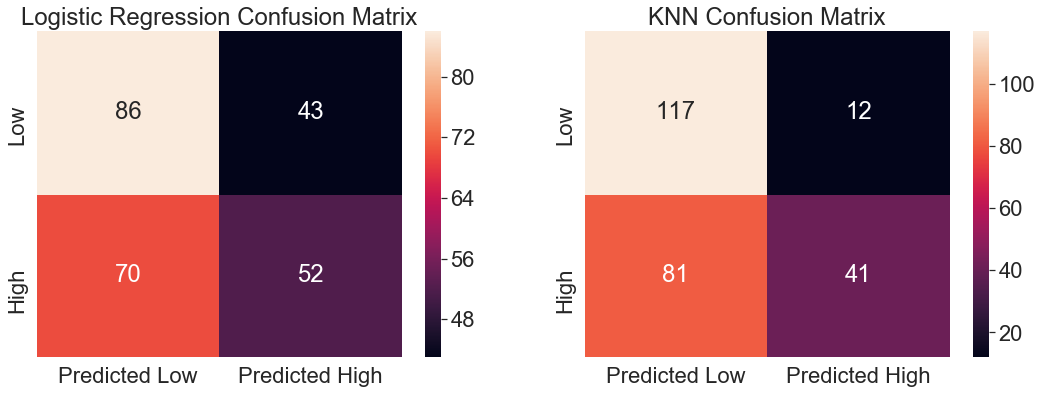

In [254]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(18,6)
dfk_cm = pd.DataFrame(cmk_test, index = ['Low','High'],columns = ['Predicted Low','Predicted High'])
df_cm = pd.DataFrame(cm_test, index = ['Low','High'],columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=2)
sns.heatmap(df_cm.iloc[-1::-1,:], annot=True,fmt= 'g', ax = axes[0])
axes[0].set_ylim([0,2]);
axes[0].set_title('Logistic Regression Confusion Matrix')
# fig.savefig('Logistic_CM.png')
sns.heatmap(dfk_cm.iloc[-1::-1,:], annot=True,fmt= 'g', ax = axes[1])
axes[1].set_ylim([0,2]);
axes[1].set_title('KNN Confusion Matrix');

## **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

In [258]:
recall = (cm_test[1][1])/cm_test.sum(axis=1)[1]
knn_recall = (cmk_test[1][1])/cmk_test.sum(axis=1)[1]
print(f'True Positive Rate (Recall) for Logistic Regression = {100*round(recall,2)} %')
print(f'True Positive Rate (Recall) for KNN = {100*round(knn_recall,2)} %')

True Positive Rate (Recall) for Logistic Regression = 43.0 %
True Positive Rate (Recall) for KNN = 34.0 %


## **False Positive Rate**
The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. 

In [259]:
fpr = (cm_test[0][1])/cm_test.sum(axis=1)[0]
knn_fpr = (cmk_test[0][1])/cmk_test.sum(axis=1)[0]
print(f'False Positive Rate for Logistic Regression = {100*round(fpr,4)} %')
print(f'False Positive Rate for KNN = {100*round(knn_fpr,4)} %')

False Positive Rate for Logistic Regression = 33.33 %
False Positive Rate for KNN = 9.3 %


## **Precision**
Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

In [260]:
precision = (cm_test[1][1])/cm_test.sum(axis=0)[1]
knn_precision = (cmk_test[1][1])/cmk_test.sum(axis=0)[1]
print(f'Precision Rate for Logistic Regression = {100*round(precision,4)} %')
print(f'Precision Rate for KNN = {100*round(knn_precision,4)} %')

Precision Rate for Logistic Regression = 54.74 %
Precision Rate for KNN = 77.36 %


## **F1 score**
Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

In [261]:
f1_score = (2*precision*recall)/(recall+precision)
knn_f1_score = (2*knn_precision*knn_recall)/(knn_recall+knn_precision)
print(f'F1 score for Logistic Regression = {100*round(f1_score,4)} %')
print(f'F1 score for KNN = {100*round(knn_f1_score,4)} %')

F1 score for Logistic Regression = 47.93 %
F1 score for KNN = 46.86 %


In [264]:
from sklearn.metrics import classification_report
print(classification_report(y[~mask],logreg.predict(X[~mask])))

              precision    recall  f1-score   support

        High       0.55      0.67      0.60       129
         Low       0.55      0.43      0.48       122

    accuracy                           0.55       251
   macro avg       0.55      0.55      0.54       251
weighted avg       0.55      0.55      0.54       251



In [265]:
from sklearn.metrics import classification_report
print(classification_report(y[~mask],neigh.predict(X[~mask])))

              precision    recall  f1-score   support

        High       0.59      0.91      0.72       129
         Low       0.77      0.34      0.47       122

    accuracy                           0.63       251
   macro avg       0.68      0.62      0.59       251
weighted avg       0.68      0.63      0.60       251



## ROC Curve

To make a ROC curve you plot the True Positive Rate, 

$$TPR=\frac{TP}{OP}$$

against the False Positive Rate,

$$FPR=\frac{FP}{ON}$$


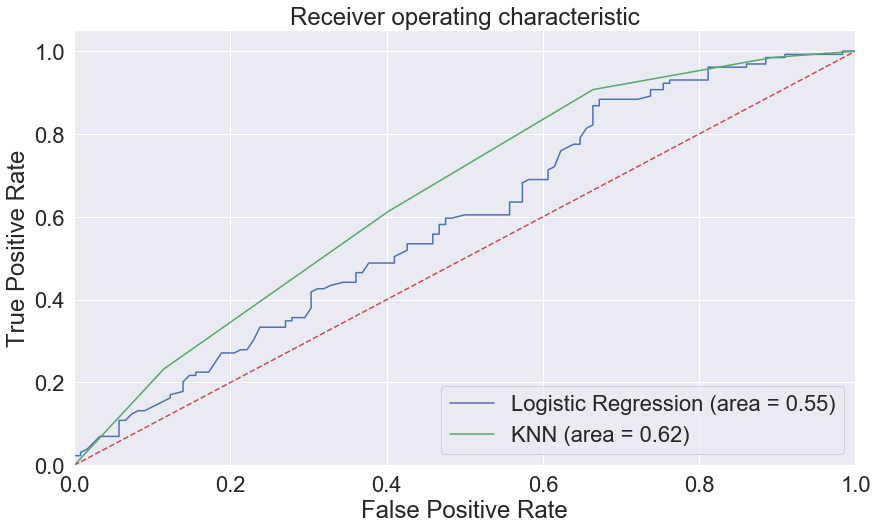

In [276]:
#Import stuff
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Area under curve - Logistic regression & KNN
yvals = 1*(y[~mask].values == 'High')
ypredvals = 1*(logreg.predict(X[~mask])=='High')
ykpredvals = 1*(neigh.predict(X[~mask])=='High')
#logreg_roc_auc = roc_auc_score(y[~mask],logreg.predict(X[~mask]))
logreg_roc_auc = roc_auc_score(yvals,ypredvals)
#knn_roc_auc = roc_auc_score(y[~mask],neigh.predict(X[~mask]))
knn_roc_auc = roc_auc_score(yvals,ykpredvals)

#ROC Curve values
fpr, tpr, thresholds = roc_curve(yvals, logreg.predict_proba(X[~mask])[:,0])
kfpr, ktpr, thresholds = roc_curve(yvals, neigh.predict_proba(X[~mask])[:,0])
fig, ax = plt.subplots(figsize = (14,8))

ax.plot(fpr, tpr, label=f'Logistic Regression (area = {logreg_roc_auc:.2f})', color = 'b')
ax.plot(kfpr, ktpr, label=f'KNN (area = {knn_roc_auc:.2f})', color = 'g')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right");